In [71]:
import pandas as pd
import json
# Import TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
# Import cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import nltk
import helper
nlp = spacy.load("en_core_web_sm")
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np

In [72]:
# Read the dataset
movies = pd.read_csv('tmdb_5000_movies.csv')
cast = pd.read_csv('tmdb_5000_credits.csv')



In [73]:
cast = cast.rename(columns={"movie_id":"id"})

cast.drop('title',inplace=True,axis = 1)
cast.drop('crew',inplace=True,axis = 1)

In [74]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [75]:
cast.head()

,id,cast
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [76]:
movies.genres = movies.genres.apply(json.loads)
cast.cast = cast.cast.apply(json.loads)

In [77]:
movies.genres = movies.genres.apply(helper.extract_genre)
cast.cast = cast.cast.apply(helper.extract_cast)
movies = movies.merge(cast, how='left', on='id')

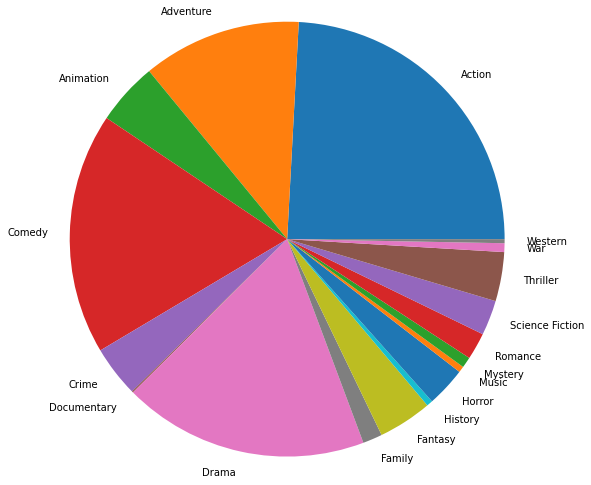

In [78]:
val = movies.groupby(['genres'])['genres'].count().apply(lambda x: x / len(movies.genres))
plt.pie(val,labels=sorted(set(movies.genres)),radius = 2.5)
plt.show() 

In [79]:
movies = helper.create_dummies(movies,"genres")
movies = helper.create_dummies(movies,"cast")

In [80]:
movies.drop('homepage',inplace=True,axis = 1)
movies.drop('id',inplace=True,axis = 1)
movies.drop('original_language',inplace=True,axis = 1)
movies.drop('keywords',inplace=True,axis = 1)
movies.drop('production_companies',inplace=True,axis = 1)
movies.drop('production_countries',inplace=True,axis = 1)
movies.drop('release_date',inplace=True,axis = 1)
movies.drop('spoken_languages',inplace=True,axis = 1)
movies.drop('status',inplace=True,axis = 1)
movies.drop('tagline',inplace=True,axis = 1)
movies.drop('vote_count',inplace=True,axis = 1)

In [81]:
movies.head()

,budget,original_title,overview,popularity,revenue,runtime,title,vote_average,genres_Action,genres_Adventure,...,cast_Woody Allen,cast_Woody Harrelson,cast_Yuri Lowenthal,cast_Yuria Nara,cast_Zac Efron,cast_Zach Braff,cast_Zach Galligan,cast_Zachary Levi,cast_Zhang Ziyi,cast_Zoe Saldana
0,237000000,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,2787965087,162.0,Avatar,7.2,1,0,...,0,0,0,0,0,0,0,0,0,0
1,300000000,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,0,1,...,0,0,0,0,0,0,0,0,0,0
2,245000000,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,880674609,148.0,Spectre,6.3,1,0,...,0,0,0,0,0,0,0,0,0,0
3,250000000,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,1084939099,165.0,The Dark Knight Rises,7.6,1,0,...,0,0,0,0,0,0,0,0,0,0
4,260000000,John Carter,"John Carter is a war-weary, former military ca...",43.926995,284139100,132.0,John Carter,6.1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
paragraph=" ".join(movies.overview.to_list())
movies.overview = movies.overview.apply(helper.get_hotwords)

In [83]:
df_duplicate_cleaned = movies
keywords, keywords_roots, keywords_select = helper.keywords_inventory(df_duplicate_cleaned,
                                                               colonne = 'overview')

Nb of keywords in variable 'overview': 5158


In [84]:
    
df_keywords_cleaned = helper.remplacement_df_keywords(df_duplicate_cleaned, keywords_select,
                                               roots = True)

In [85]:
movies = df_keywords_cleaned

In [86]:
syn_dict = helper.create_syndict(movies)

In [87]:
for index, row in movies.iterrows():
    words = row.overview.split(" ")
    for word in words:
        max_occ = 0
        syn_toreplace = ""
        syns = helper.get_synonymes(word)
        syns.add(word)
        syns = set(syns)
        if len(syns) > 1:
            for syn in syns:
                if len(syn) < 3:
                    continue
                occ = syn_dict[syn]
                if occ > max_occ:
                    max_occ = occ
                    syn_toreplace = syn 
            new = movies.iloc[index].overview.replace(word,syn_toreplace).split(" ")
            movies.at[index, 'overview'] = " ".join(set(new))

            #movies.loc[index, 'overview'] = set(movies.iloc[index].overview.replace(word,syn_toreplace))

In [88]:
# Compute the Cosine Similarity
tfidf = TfidfVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}', 
                      stop_words = 'english')

# Filling NaNs with empty string
df_keywords_cleaned['overview'] = movies['overview'].fillna('')

# Fitting the TF-IDF on the 'overview' text
tfidf_matrix = tfidf.fit_transform(df_keywords_cleaned['overview'])

tfidf_matrix.shape

(2000, 4415)

In [89]:
df1 = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())
print(df1)

      1000  10th  119  15th  1700s  1910  1950s  1970s  1980s   26  ...  \
0      0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
1      0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
2      0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
3      0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
4      0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
...    ...   ...  ...   ...    ...   ...    ...    ...    ...  ...  ...   
1995   0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
1996   0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
1997   0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
1998   0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   
1999   0.0   0.0  0.0   0.0    0.0   0.0    0.0    0.0    0.0  0.0  ...   

      zebra  zeta  zimmer  zip  zodiac  zoe  zone  zookeeper  zoological  \
0       0.0   0.0     0

c:\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [90]:
res = pd.concat([df_keywords_cleaned, df1], axis=1)


In [91]:
res.head()

,budget,original_title,overview,popularity,revenue,runtime,title,vote_average,genres_Action,genres_Adventure,...,zebra,zeta,zimmer,zip,zodiac,zoe,zone,zookeeper,zoological,zorro
0,237000000,Avatar,pandora society moonshine culture one c marin ...,150.437577,2787965087,162.0,Avatar,7.2,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,300000000,Pirates of the Caribbean: At World's End,spirit bound world,139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,245000000,Spectre,tense past level skin power harmonium trueness...,107.376788,880674609,148.0,Spectre,6.3,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,250000000,The Dark Knight Rises,end answer scourge drawing dominion criminal s...,112.312950,1084939099,165.0,The Dark Knight Rises,7.6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260000000,John Carter,selection world planet threshold barsoom man c...,43.926995,284139100,132.0,John Carter,6.1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# Create a pandas series with movie titles as indices and indices as series values 
indices = pd.Series(movies.index, index=movies['original_title'])

In [93]:
res = res.drop('original_title',axis = 1)
res = res.drop('title',axis = 1)
res = res.drop('overview',axis = 1)
res = res.drop('popularity',axis = 1)
res = res.drop('budget',axis = 1)
res = res.drop('runtime',axis = 1)
res = res.drop('revenue',axis = 1)
res = res.drop('vote_average',axis = 1)

In [94]:
similarity_matrix = cosine_similarity(res)

In [95]:
title="Inception"

# Get the index corresponding to movie title
index = indices[title]

# Get the cosine similarity scores 
similarity_scores = list(enumerate(similarity_matrix[index]))


# Sort the similarity scores in descending order
sorted_similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)


# Top-10 most similar movie scores
top_10_movies_scores = sorted_similarity_scores[1:5]

# Get movie indices
top_10_movie_indices=[]
for i in top_10_movies_scores:
    top_10_movie_indices.append(i[0])
    
# Top 10 recommende movie
movies['original_title'].iloc[top_10_movie_indices]

622                   Body of Lies
1380      The Man in the Iron Mask
1701    Once Upon a Time in Mexico
914           Central Intelligence
Name: original_title, dtype: object

In [96]:
" ".join(movies[movies['original_title']=="Inception"].overview)

'someone fortune espionage mark subconscious spirit job requital origin stealer implantation mind'

In [97]:
" ".join(movies[movies['original_title']=="Once Upon a Time in Mexico"].overview)

'general espionage factor'

In [98]:
" ".join(movies[movies['original_title']=="Central Intelligence"].overview)

'world espionage facebook brother story'